Credits to: Lalit Bangad, Yagmur Bayraktar, Xander Carruth, and Vinay Deshmukh

In [ ]:
import random
from tqdm import tqdm
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from zipfile import ZipFile
import os
import itertools
import multiprocessing
from collections import deque, defaultdict
!pip install node2vec


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Download the combined txt files
!wget https://snap.stanford.edu/data/facebook_combined.txt.gz
!gunzip -f facebook_combined.txt.gz

# Download the tar gz
!wget https://snap.stanford.edu/data/facebook.tar.gz
! tar -xf facebook.tar.gz


--2022-12-06 03:58:10--  https://snap.stanford.edu/data/facebook_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218576 (213K) [application/x-gzip]
Saving to: ‘facebook_combined.txt.gz’

facebook_combined.t 100%[===================>] 213.45K   199KB/s    in 1.1s    

2022-12-06 03:58:12 (199 KB/s) - ‘facebook_combined.txt.gz’ saved [218576/218576]

--2022-12-06 03:58:12--  https://snap.stanford.edu/data/facebook.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 732104 (715K) [application/x-gzip]
Saving to: ‘facebook.tar.gz.2’

facebook.tar.gz.2   100%[===================>] 714.95K   331KB/s    in 2.2s    

2022-12-06 03:58:15 (331 KB/s) - ‘facebook.tar.gz.2’ sa

In [ ]:
EGO = 107
DIR = './facebook/'


In [ ]:
rows = []
with open(f'{DIR}/{EGO}.featnames') as f:
    for line in f:
        # trim newline from end
        line = line.strip()

        # remove "index"
        line = line.split(' ', 1)[1]
        raw_feature_name = line


        # Split on semi colon on right side
        # Now line is a list of 2 items
        # [0] is the "name", [1] is "anonymized feature 0"
        line = line.rsplit(';', 1)

        raw_value = line[1]

        # Remove the words "anonymized feature"
        line[1] = line[1].rsplit(' ', 1)[1]

        rows.append({
          'Feature Category': line[0],
          'Feature Num': line[1],
          'Raw Value': raw_value,
          'Feature': raw_feature_name
        })


featnames = pd.DataFrame(data=rows)
featnames.head()

,Feature Category,Feature Num,Raw Value,Feature
0,birthday,376,anonymized feature 376,birthday;anonymized feature 376
1,birthday,0,anonymized feature 0,birthday;anonymized feature 0
2,birthday,1,anonymized feature 1,birthday;anonymized feature 1
3,birthday,209,anonymized feature 209,birthday;anonymized feature 209
4,birthday,2,anonymized feature 2,birthday;anonymized feature 2


In [ ]:
edges = pd.read_csv(f'{DIR}/{EGO}.edges', delim_whitespace=True, header=None)
edges.head()

,0,1
0,953,1323
1,1789,1707
2,1175,1059
3,1329,1559
4,1804,1898


In [ ]:
names = featnames['Feature'].T
feat = pd.read_csv(f'{DIR}/{EGO}.feat', delim_whitespace=True, header=None, index_col=0, names=names)

ego_row_file = f'{DIR}/{EGO}.egofeat'
with open(ego_row_file) as f:
  row = f.read().strip().split(' ')

feat.loc[EGO] = list(map(int, row))
feat.tail()

,birthday;anonymized feature 376,birthday;anonymized feature 0,birthday;anonymized feature 1,birthday;anonymized feature 209,birthday;anonymized feature 2,birthday;anonymized feature 3,birthday;anonymized feature 210,birthday;anonymized feature 4,birthday;anonymized feature 5,birthday;anonymized feature 6,...,work;start_date;anonymized feature 168,work;start_date;anonymized feature 202,work;start_date;anonymized feature 169,work;start_date;anonymized feature 170,work;start_date;anonymized feature 171,work;start_date;anonymized feature 681,work;start_date;anonymized feature 203,work;with;id;anonymized feature 727,work;with;id;anonymized feature 728,work;with;id;anonymized feature 683
1908,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1911,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Circle Separation Code

In [ ]:
# Drop all of the features that were manually evaluated as unimportant
feat = feat[feat.columns.drop(list(feat.filter(regex='work;start_date')))]
feat = feat[feat.columns.drop(list(feat.filter(regex='work;projects')))]
feat = feat[feat.columns.drop(list(feat.filter(regex='work;position')))]
feat = feat[feat.columns.drop(list(feat.filter(regex='work;end_date')))]
feat = feat[feat.columns.drop(list(feat.filter(regex='middle_name')))]
feat = feat[feat.columns.drop(list(feat.filter(regex='languages')))]
feat = feat[feat.columns.drop(list(feat.filter(regex='first_name')))]
feat = feat[feat.columns.drop(list(feat.filter(regex='birthday')))]
# Turn node id into a column
feat.reset_index(inplace=True)
feat = feat.rename(columns = {'index':'Node ID'})

In [ ]:
# SCARCITY SEPARATION
# 1. Generate list of percent of how much each column matches ego node
# Dict of number of scarcity of matches to the ego for each feature
egocol_dict = {}
# Create df with only ego
ego_feat = feat[feat['Node ID'] == EGO]
# Create df without the go
node_feat = feat[feat['Node ID'] != EGO]
node_feat = node_feat[node_feat.columns.drop('Node ID')]
for (columnName, columnData) in node_feat.iteritems():
  # Calculate the number of nodes that match the ego on the column feature
  matches = len(node_feat[node_feat[columnName]==ego_feat[columnName].iloc[0]])
  # Calculate the scarcity of matches
  egocol_dict[columnName] = round(matches/len(node_feat[columnName]), 8)*100

# 2. Sort dict
egocol_dict = sorted(egocol_dict.items(), key=lambda item: item[1])
print(egocol_dict)

# 3. Take top 30 features of list
scsim_items = list(zip(*egocol_dict))[0][:30]
print(scsim_items)

[('education;year;id;anonymized feature 70', 0.47846900000000003), ('education;degree;id;anonymized feature 22', 5.5502389999999995), ('education;school;id;anonymized feature 52', 9.952153), ('last_name;anonymized feature 273', 10.813397), ('education;year;id;anonymized feature 66', 17.224880000000002), ('education;type;anonymized feature 55', 29.377989999999997), ('education;type;anonymized feature 54', 31.770335), ('education;school;id;anonymized feature 538', 32.822967), ('gender;anonymized feature 78', 64.688995), ('gender;anonymized feature 77', 65.837321), ('locale;anonymized feature 127', 70.526316), ('locale;anonymized feature 278', 73.301435), ('hometown;id;anonymized feature 84', 74.641148), ('education;type;anonymized feature 53', 78.660287), ('education;year;id;anonymized feature 61', 83.25358899999999), ('location;id;anonymized feature 84', 84.784689), ('education;year;id;anonymized feature 62', 86.698565), ('education;year;id;anonymized feature 64', 86.698565), ('last_nam

[[-0.04376881 -0.18048963 -0.08779026 ... -0.04376881 -0.04376881
  -0.04376881]
 [-0.04376881 -0.18048963 -0.08779026 ... -0.04376881 -0.04376881
  -0.04376881]
 [-0.04376881 -0.18048963 -0.08779026 ... -0.04376881 -0.04376881
  -0.04376881]
 ...
 [-0.04376881 -0.18048963 -0.08779026 ... -0.04376881 -0.04376881
  -0.04376881]
 [-0.04376881 -0.18048963 -0.08779026 ... -0.04376881 -0.04376881
  -0.04376881]
 [-0.04376881 -0.18048963 -0.08779026 ... -0.04376881 -0.04376881
  -0.04376881]]


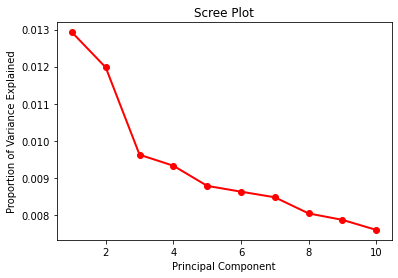

[[0.00500258 0.10982622 0.01485897 ... 0.10126216 0.02744055 0.03304628]
 [0.01352184 0.05049107 0.02368295 ... 0.04891825 0.01474346 0.01414783]
 [0.01205078 0.05346251 0.03939226 ... 0.01332725 0.05160934 0.06873516]]


In [ ]:
# PCA Separation
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize data and run PCA
sfeat = feat[feat.columns.drop('Node ID')]
scaler = StandardScaler()
sfeat = scaler.fit_transform(sfeat)
print(sfeat[:10])
pca = PCA(n_components = 10)
pfeat = pca.fit_transform(sfeat)

# Create skree plot of eigenvalues
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

print(abs(pca.components_[:3]))


In [ ]:
# Take top 10 components for each PCA
comp_1 = np.argpartition(abs(pca.components_[0]), -10)[-10:]
print("Component 1")
print(comp_1)
print(feat.columns[comp_1])
print(abs(pca.components_[0])[comp_1])
print()

print("Component 2")
comp_2 = np.argpartition(abs(pca.components_[1]), -10)[-10:]
print(comp_2)
print(feat.columns[comp_2])
print(abs(pca.components_[1])[comp_2])
print()

print("Component 3")
comp_3 = np.argpartition(abs(pca.components_[2]), -10)[-10:]
print(comp_3)
print(feat.columns[comp_3])
print(abs(pca.components_[2])[comp_3])

# Create list of 30 features, the top 10 from each of the top 3 principle components
pcasim_items = np.array([])
pcasim_items = np.append(pcasim_items, feat.columns[comp_1])
pcasim_items = np.append(pcasim_items, feat.columns[comp_2])
pcasim_items = np.append(pcasim_items, feat.columns[comp_3])

Component 1
[231 232 203 302 372 200   6  69  63 204]
Index(['education;year;id;anonymized feature 72',
       'gender;anonymized feature 77',
       'education;school;id;anonymized feature 538',
       'locale;anonymized feature 278',
       'work;employer;id;anonymized feature 150',
       'education;school;id;anonymized feature 536',
       'education;concentration;id;anonymized feature 386',
       'education;degree;id;anonymized feature 436',
       'education;degree;id;anonymized feature 433',
       'education;type;anonymized feature 53'],
      dtype='object')
[0.14695756 0.15047371 0.15445759 0.15226567 0.1561586  0.20569002
 0.1831737  0.1607081  0.18797751 0.24829037]

Component 2
[ 93 138 319 325 199 202 300 218  87 301]
Index(['education;school;id;anonymized feature 453',
       'education;school;id;anonymized feature 316',
       'location;id;anonymized feature 616',
       'location;id;anonymized feature 138',
       'education;school;id;anonymized feature 535',
       '

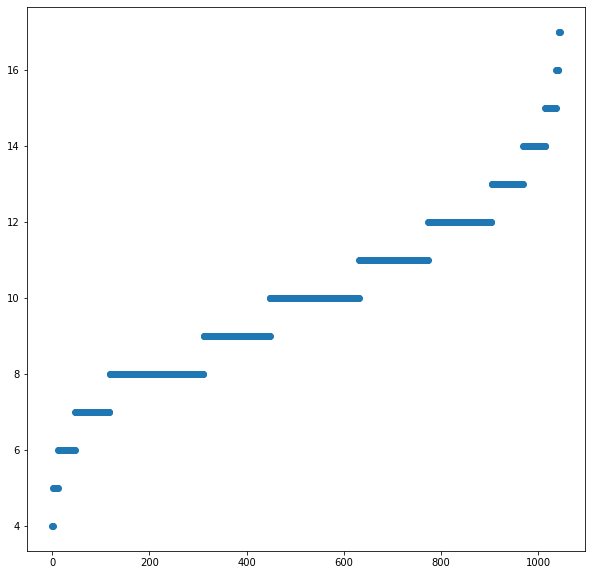

In [ ]:
# SCARCITY SIMILARITY DISTRIBUTION ANALYSIS
from scipy.spatial.distance import hamming
# Create df with only ego
scsim_items = list(scsim_items)
ego_feat = feat[feat['Node ID'] == EGO]
ego_feat = ego_feat[scsim_items]
# Create df without the ego
node_feat = feat[feat['Node ID'] != EGO]
node_feat = node_feat[scsim_items]

ego_feat_list = ego_feat.iloc[0].tolist()
sc_sims = np.array([])
# Take hamming distance for all nodes
for idx, row in node_feat.iterrows():
  similarity = hamming(ego_feat_list, row.tolist()) * len(ego_feat_list)
  sc_sims = np.append(sc_sims, similarity)
sc_simss = np.sort(sc_sims)
# Plot the similarities of the nodes
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
indices = [i for i, val in enumerate(sc_simss)]
plt.scatter(indices, sc_simss)
plt.show()

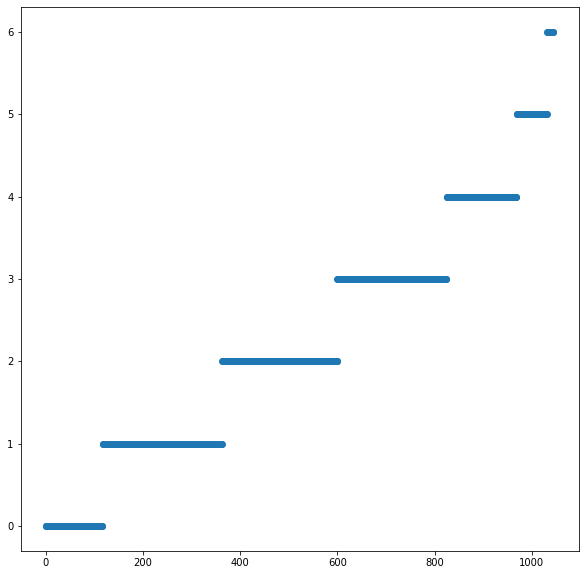

In [ ]:
# PCA SIMILARITY DISTRIBUTION ANALYSIS
from scipy.spatial.distance import hamming
# Create df with only ego
ego_feat = feat[feat['Node ID'] == EGO]
ego_feat = ego_feat[pcasim_items.tolist()]
# Create df without the ego
node_feat = feat[feat['Node ID'] != EGO]
node_feat = node_feat[pcasim_items]

ego_feat_list = ego_feat.iloc[0].tolist()
pca_sims = np.array([])
# Take hamming distance for all nodes
for idx, row in node_feat.iterrows():
  similarity = hamming(ego_feat_list, row.tolist()) * len(ego_feat_list)
  pca_sims = np.append(pca_sims, similarity)
pca_sims = np.sort(pca_sims)
# Plot the similarities of the nodes
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
indices = [i for i, val in enumerate(pca_sims)]
plt.scatter(indices, pca_sims)
plt.show()

In [ ]:
# HERE, SCARCITY IS CHOSEN OVER PCA
import sys
n_feat = feat[feat['Node ID'] != EGO]
n_feat = n_feat[np.append(pcasim_items, 'Node ID')]
# Create lists of top 1.5, 5, 15, and 50 nodes
circle1_nodes = np.argpartition(sc_sims, -round(len(sc_sims)*0.01))[-round(len(sc_sims)*0.01):]
circle1_nodes = n_feat.iloc[circle1_nodes]['Node ID'].tolist()
print(circle1_nodes)
circle2_nodes = np.argpartition(sc_sims, -round(len(sc_sims)*1/30))[-round(len(sc_sims)*1/30):]
circle2_nodes = n_feat.iloc[circle2_nodes]['Node ID'].tolist()
circle3_nodes = np.argpartition(sc_sims, -round(len(sc_sims)*0.1))[-round(len(sc_sims)*0.1):]
circle3_nodes = n_feat.iloc[circle3_nodes]['Node ID'].tolist()
circle4_nodes = np.argpartition(sc_sims, -round(len(sc_sims)*1/3))[-round(len(sc_sims)*1/3):]
circle4_nodes = n_feat.iloc[circle4_nodes]['Node ID'].tolist()

[1338, 1392, 989, 1893, 965, 1751, 1764, 1875, 1725, 1841]


## Code for Largest Circle (Circle 5)

In [ ]:
def describe_graph(g):
  print(nx.info(g))
  print('Edges', nx.number_of_edges(g))
  print('Nodes', nx.number_of_nodes(g))
  print('Density', nx.density(g))
  print('Degree', nx.degree(g))

In [ ]:
existing_edges = []

for i in feat.index:
  if EGO == i:
    continue
  existing_edges.append( (EGO, i))
for i,(a,b) in edges.iterrows():
  # print(a,b)
  if a == b:
    continue
  existing_edges.append( (a,b) )

existing_edges[:10]

[(107, 0),
 (107, 1),
 (107, 2),
 (107, 3),
 (107, 4),
 (107, 5),
 (107, 6),
 (107, 7),
 (107, 8),
 (107, 9)]

In [ ]:

G = nx.Graph()
for node in feat['Node ID']:
   G.add_node(node)
G.add_edges_from(existing_edges)
# nx.set_node_attributes(G, node_attributes)

describe_graph(G)

# This whole thing is circle5 (where it is centered on ego node)
circle5 = G

Graph with 1912 nodes and 27794 edges
Edges 27794
Nodes 1912
Density 0.015213616827484133
Degree [(896, 126), (897, 66), (898, 38), (899, 3), (900, 13), (901, 34), (902, 46), (903, 34), (904, 3), (905, 17), (906, 78), (907, 13), (908, 32), (909, 12), (910, 5), (911, 1), (912, 9), (913, 44), (914, 16), (915, 35), (916, 147), (917, 130), (918, 1), (919, 29), (920, 13), (921, 106), (922, 30), (923, 8), (924, 45), (925, 167), (926, 21), (927, 75), (928, 9), (929, 5), (930, 52), (931, 15), (932, 63), (933, 25), (934, 82), (935, 7), (936, 37), (937, 7), (938, 29), (939, 17), (940, 17), (941, 54), (942, 65), (943, 12), (944, 37), (945, 4), (946, 166), (947, 115), (948, 38), (949, 23), (950, 10), (951, 20), (952, 84), (953, 109), (954, 55), (955, 10), (956, 10), (957, 65), (958, 24), (959, 46), (960, 103), (961, 13), (962, 27), (963, 33), (964, 26), (965, 16), (966, 115), (967, 107), (968, 40), (969, 32), (970, 15), (971, 34), (972, 21), (973, 18), (974, 11), (975, 54), (976, 24), (977, 26), (

EGO Node graph has been created





## Code for Circles 1-4

In [ ]:
def describe_graph(g):
  print(nx.info(g))
  print('Edges', nx.number_of_edges(g))
  print('Nodes', nx.number_of_nodes(g))
  print('Density', nx.density(g))
  print('Degree', nx.degree(g))

In [ ]:
c1_edges = []
c2_edges = []
c3_edges = []
c4_edges = []

# Create edge lists for the circles
for i in circle1_nodes:
  c1_edges.append( (EGO, i) )
for i in circle2_nodes:
  c2_edges.append( (EGO, i) )
for i in circle3_nodes:
  c3_edges.append( (EGO, i) )
for i in circle4_nodes:
  c4_edges.append( (EGO, i) )
for i,(a,b) in edges.iterrows():
  if a in circle1_nodes and b in circle1_nodes:
    c1_edges.append( (a,b) )
    c2_edges.append( (a,b) )
    c3_edges.append( (a,b) )
    c4_edges.append( (a,b) )
  elif a in circle2_nodes and b in circle2_nodes:
    c2_edges.append( (a,b) )
    c3_edges.append( (a,b) )
    c4_edges.append( (a,b) )
  elif a in circle3_nodes and b in circle3_nodes:
    c3_edges.append( (a,b) )
    c4_edges.append( (a,b) )
  elif a in circle4_nodes and b in circle4_nodes:
    c4_edges.append( (a,b) )


print(c1_edges)
print(c2_edges)
print(c3_edges)
print(c4_edges)

[(107, 1338), (107, 1392), (107, 989), (107, 1893), (107, 965), (107, 1751), (107, 1764), (107, 1875), (107, 1725), (107, 1841), (1725, 1338), (1875, 1841), (1751, 1875), (1841, 1875), (1875, 1751), (1338, 1725), (1875, 989), (989, 1751), (989, 1875), (1751, 989), (1893, 1751), (1751, 1893)]
[(107, 1479), (107, 933), (107, 1894), (107, 1148), (107, 1201), (107, 942), (107, 1576), (107, 1354), (107, 1215), (107, 1495), (107, 1014), (107, 596), (107, 965), (107, 1725), (107, 989), (107, 1893), (107, 1751), (107, 1169), (107, 1875), (107, 1000), (107, 1392), (107, 1706), (107, 1595), (107, 1032), (107, 1850), (107, 1489), (107, 1488), (107, 1647), (107, 1841), (107, 1764), (107, 1830), (107, 1324), (107, 1315), (107, 1820), (107, 1338), (942, 1215), (1489, 1495), (1706, 1032), (1850, 1725), (596, 1148), (1032, 942), (1841, 1576), (1725, 1338), (1850, 1893), (1148, 1820), (1014, 942), (1893, 1324), (1820, 1014), (1324, 1875), (1495, 942), (1820, 1324), (1148, 1315), (1595, 1894), (1875, 18

In [ ]:
def create_graph(circle_list, edges):
  G = nx.Graph()
  G.add_node(EGO)
  for node in circle_list:
    G.add_node(node)
  G.add_edges_from(edges)
  describe_graph(G)
  return G

# Create graphs for the circles
circle1 = create_graph(circle1_nodes, c1_edges)
circle2 = create_graph(circle2_nodes, c2_edges)
circle3 = create_graph(circle3_nodes, c3_edges)
circle4 = create_graph(circle4_nodes, c4_edges)

Graph with 11 nodes and 16 edges
Edges 16
Nodes 11
Density 0.2909090909090909
Degree [(107, 10), (1338, 2), (1392, 1), (989, 3), (1893, 2), (965, 1), (1751, 4), (1764, 1), (1875, 4), (1725, 2), (1841, 2)]
Graph with 36 nodes and 147 edges
Edges 147
Nodes 36
Density 0.23333333333333334
Degree [(107, 35), (1479, 9), (933, 7), (1894, 11), (1148, 9), (1201, 1), (942, 14), (1576, 7), (1354, 1), (1215, 11), (1495, 13), (1014, 17), (596, 5), (965, 1), (1725, 5), (989, 5), (1893, 15), (1751, 11), (1169, 1), (1875, 8), (1000, 2), (1392, 4), (1706, 10), (1595, 10), (1032, 15), (1850, 9), (1489, 7), (1488, 1), (1647, 7), (1841, 7), (1764, 2), (1830, 2), (1324, 11), (1315, 7), (1820, 12), (1338, 2)]
Graph with 105 nodes and 752 edges
Edges 752
Nodes 105
Density 0.13772893772893774
Degree [(107, 104), (1020, 21), (1001, 2), (999, 1), (1872, 15), (1873, 9), (1435, 7), (1074, 3), (1633, 4), (1244, 4), (1820, 30), (1636, 25), (1315, 17), (1284, 26), (1324, 19), (1448, 11), (1812, 17), (1127, 6), (1428

In [ ]:
describe_graph(circle1)

x = nx.intersection(circle1, circle2)
describe_graph(x)

Graph with 11 nodes and 16 edges
Edges 16
Nodes 11
Density 0.2909090909090909
Degree [(107, 10), (1338, 2), (1392, 1), (989, 3), (1893, 2), (965, 1), (1751, 4), (1764, 1), (1875, 4), (1725, 2), (1841, 2)]
Graph with 11 nodes and 16 edges
Edges 16
Nodes 11
Density 0.2909090909090909
Degree [(1764, 1), (965, 1), (1893, 2), (107, 10), (1392, 1), (1841, 2), (989, 3), (1875, 4), (1751, 4), (1338, 2), (1725, 2)]


Plot the 4 Circles

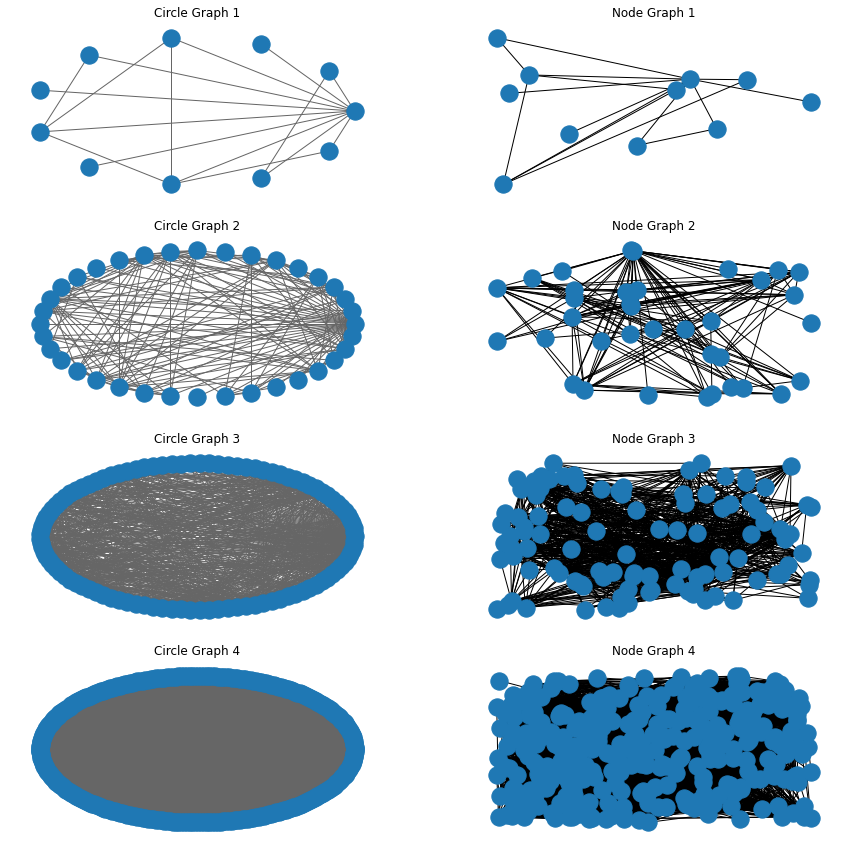

In [ ]:
# subplots

def subplot_circle(G, n, ax):
  # Circular layout
  pos = nx.circular_layout(G)

  circle_ax = ax[0]
  nx.draw_networkx(G, pos, with_labels=False, edge_color='.4', ax=circle_ax)
  circle_ax.set_title("Circle Graph " + str(n))
  circle_ax.axis('off')


  node_ax = ax[1]
  pos = nx.random_layout(G)
  nx.draw_networkx(G, pos, with_labels=False, ax=node_ax)

  node_ax.set_title("Node Graph " + str(n))
  node_ax.axis('off')

fig, ax = plt.subplots(4, 2, figsize=(15, 15))
subplot_circle(circle1, 1, ax[0])
subplot_circle(circle2, 2, ax[1])
subplot_circle(circle3, 3, ax[2])
subplot_circle(circle4, 4, ax[3])

# Inspect the graphs below

In [ ]:
describe_graph(circle1)
describe_graph(circle2)
describe_graph(circle3)
describe_graph(circle4)

Graph with 11 nodes and 16 edges
Edges 16
Nodes 11
Density 0.2909090909090909
Degree [(107, 10), (1338, 2), (1392, 1), (989, 3), (1893, 2), (965, 1), (1751, 4), (1764, 1), (1875, 4), (1725, 2), (1841, 2)]
Graph with 36 nodes and 147 edges
Edges 147
Nodes 36
Density 0.23333333333333334
Degree [(107, 35), (1479, 9), (933, 7), (1894, 11), (1148, 9), (1201, 1), (942, 14), (1576, 7), (1354, 1), (1215, 11), (1495, 13), (1014, 17), (596, 5), (965, 1), (1725, 5), (989, 5), (1893, 15), (1751, 11), (1169, 1), (1875, 8), (1000, 2), (1392, 4), (1706, 10), (1595, 10), (1032, 15), (1850, 9), (1489, 7), (1488, 1), (1647, 7), (1841, 7), (1764, 2), (1830, 2), (1324, 11), (1315, 7), (1820, 12), (1338, 2)]
Graph with 105 nodes and 752 edges
Edges 752
Nodes 105
Density 0.13772893772893774
Degree [(107, 104), (1020, 21), (1001, 2), (999, 1), (1872, 15), (1873, 9), (1435, 7), (1074, 3), (1633, 4), (1244, 4), (1820, 30), (1636, 25), (1315, 17), (1284, 26), (1324, 19), (1448, 11), (1812, 17), (1127, 6), (1428

In [ ]:
xg = list(nx.connected_components(circle5))
for g in xg:
  print(g)
len(xg)

print('strong')



{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [ ]:
# use unsupervised features for classification

# Returns a set of nodes that are the neighbors of a node
# def neighborhood(graph: nx.Graph, node: int) -> Set[int]:
#   return graph.neighbors(node)


CIRCLES = [
    circle1,
    circle2,
    circle3,
    circle4,
    circle5,
]
def get_common_circle(nodeA, nodeB) -> nx.Graph:
  # Get common circle innermost for both
  aCircNum = 5
  if nodeA in circle1 and nodeB in circle1:
    aCircNum = 1
  elif nodeA in circle2 and nodeB in circle2:
    aCircNum = 2
  elif nodeA in circle3 and nodeB in circle3:
    aCircNum = 3
  elif nodeA in circle4 and nodeB in circle4:
    aCircNum = 4
  return CIRCLES[aCircNum - 1]


# Similarity metrics
def common_neighbors(nodeA, nodeB):
  # Get common circle number

  graph = get_common_circle(nodeA, nodeB)

  nA = set(graph.neighbors(nodeA))
  nB = set(graph.neighbors(nodeB))
  return len(nA & nB)

def jaccard_coefficient(nodeA, nodeB):

  graph = get_common_circle(nodeA, nodeB)

  ebunch = [
      (nodeA, nodeB)
  ]

  return next(nx.jaccard_coefficient(graph, ebunch=ebunch))[2]

def resource_allocation_index(nodeA, nodeB):
  graph = get_common_circle(nodeA, nodeB)

  ebunch = [
      (nodeA, nodeB)
  ]
  return next(nx.resource_allocation_index(graph, ebunch=ebunch))[2]

def adamic_adar_index(nodeA, nodeB):

  graph = get_common_circle(nodeA, nodeB)

  ebunch = [
      (nodeA, nodeB)
  ]
  return next(nx.adamic_adar_index(graph, ebunch=ebunch))[2]

def preferential_attachment(nodeA, nodeB):
  graph = get_common_circle(nodeA, nodeB)

  ebunch = [
      (nodeA, nodeB)
  ]
  return next(nx.preferential_attachment(graph, ebunch=ebunch))[2]

def common_neighbor_centrality(nodeA, nodeB):

  graph = get_common_circle(nodeA, nodeB)

  ebunch = [
      (nodeA, nodeB)
  ]
  return next(nx.common_neighbor_centrality(graph, ebunch=ebunch))[2]



# Reference only

nx.connected_components(circle5)

<generator object connected_components at 0x7f5ac38ad580>

# Get edges (positive and negative)

In [ ]:
# Step 1:

#region Get negative samples
# Returns list of edges that don't have a direct edge, but have a path
def get_negative_edges(circle: nx.Graph):

  list_no_direct_edges = []

  nodes = list(circle.nodes())
  adj_matrix = nx.to_numpy_matrix(G, nodelist=nodes)
  adj_matrix.shape

  node_count = len(nodes)
  shape = adj_matrix.shape
  # Ensure square matrix
  assert shape[0] == shape[1]
  assert shape[0] == node_count

  # Iterate matrix
  for r, c in tqdm(
      itertools.combinations_with_replacement(
          range(node_count), r = 2
    )):
      if r == c:
        continue
      if adj_matrix[r, c] != 0:
        continue

      list_no_direct_edges.append(
          (nodes[r], nodes[c])
      )

  # SAMPLE_SIZE = 4000
  # nodes_sample = sorted(random.sample(list_no_direct_edges, k=SAMPLE_SIZE))
  nodes_sample = sorted(random.sample(
      list_no_direct_edges,
      k = 27000
      ))
  # print(len(list_no_direct_edges))
  # return

  nodes_transitive_reachable = []
  for tup in tqdm(nodes_sample):
    nodeA, nodeB = tup
    if nx.has_path(G, nodeA, nodeB):
      nodes_transitive_reachable.append(
          (nodeA, nodeB)
      )
  return nodes_transitive_reachable
#endregion


#region
def get_positive_edges(circle: nx.Graph):
  # def get_positive_edges(circle: nx.Graph):
  edges =  np.array(circle.edges())
  ncc = nx.number_connected_components(circle)
  print("No of connected components:-", ncc)
  largest_cc = max(nx.connected_components(circle), key=len)
  print("Largest cc:-", len(largest_cc))

  edgeMap = defaultdict(list)
  for a,b in edges:
    edgeMap[a].append(b)
    edgeMap[b].append(a)

  print("Edge Map is:-", edgeMap)
  nodes = list(circle.nodes())
  n = len(nodes)


  disc, low, time, ans = [0] * n, [0] * n, [1], []

  def dfs(curr: int, prev: int):
    disc[curr] = low[curr] = time[0]
    time[0] += 1
    for next in edgeMap[curr]:
      if not disc[next]:
        dfs(next, curr)
        low[curr] = min(low[curr], low[next])
      elif next != prev:
        low[curr] = min(low[curr], disc[next])
      if low[next] > disc[curr]:
        ans.append([curr, next])
  dfs(EGO, -1)
  print("Answer is:-", ans)
  critical_edges = ans

  removable_edges = list(

      set(map(tuple, edges)) - set(map(tuple, critical_edges))
  )

  return removable_edges


#endregion
import time

start = time.time()
negative_edges = get_negative_edges(circle5)

positive_edges = get_positive_edges(circle5)

end = time.time()

print('edge counts')
print(f'Count of negative edges : {len(negative_edges)}')
print(f'Count of positive edges : {len(positive_edges)}')
print(f'Time taken: {end- start}')



1828828it [00:06, 284101.87it/s]
100%|██████████| 27000/27000 [00:07<00:00, 3668.11it/s]


No of connected components:- 10
Largest cc:- 1903
Edge Map is:- defaultdict(<class 'list'>, {896: [107, 1479, 1081, 1587, 1115, 1345, 1292, 1303, 1235, 1647, 1170, 1204, 1019, 1347, 1324, 1706, 1438, 994, 1322, 1015, 1060, 902, 1298, 1728, 1350, 1315, 1221, 1257, 1100, 1857, 1404, 1903, 1578, 1102, 1215, 1018, 989, 1192, 1715, 1495, 1764, 1229, 1515, 1104, 1448, 975, 1284, 1850, 957, 988, 1751, 1120, 1636, 1790, 483, 1462, 1036, 1454, 1893, 1596, 984, 1872, 1067, 1871, 1583, 1611, 1812, 1396, 1044, 1899, 1459, 1502, 1661, 1277, 1824, 1841, 1286, 1716, 1475, 1148, 1273, 1573, 1423, 1373, 1628, 1392, 637, 1379, 1550, 1261, 1381, 1014, 1032, 1007, 1009, 1638, 981, 1720, 1732, 1591, 1432, 1129, 1282, 1576, 1417, 1786, 954, 1595, 1691, 1108, 1783, 1227, 1413, 1859, 1021, 1875, 1862, 1680, 1231, 1742, 1158, 1873, 1635, 1426, 1190, 1082], 107: [896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 

In [ ]:
list(nx.nodes_with_selfloops(circle1))
list(nx.nodes_with_selfloops(circle2))
list(nx.nodes_with_selfloops(circle3))
list(nx.nodes_with_selfloops(circle4))
list(nx.nodes_with_selfloops(circle5))

[]

In [ ]:
import time

start = time.time()

df = pd.DataFrame({
  'Node 1': pd.Series(dtype='int64'),
  'Node 2': pd.Series(dtype='int64'),
  'CN': pd.Series(dtype='float'),
  'JC': pd.Series(dtype='float'),
  'RA': pd.Series(dtype='float'),
  'AA': pd.Series(dtype='float'),
  'PA': pd.Series(dtype='float'),
  'Connection': pd.Series(dtype='int')
}

                  )

df.set_index(['Node 1', 'Node 2'], inplace=True)


def get_edge_con():

  # Zip (edge, 1)
  positive_zip = zip(
      positive_edges,
      itertools.cycle([1])
  )

  # Zip (edge, 0)
  negative_zip = zip(
      negative_edges,
      itertools.cycle([0])
  )

  return itertools.chain(
      positive_zip,
      negative_zip
  )

# Determine the graph for each edge
graph_map = defaultdict(list)
for (a,b), conn in get_edge_con():


  graph = get_common_circle(a, b)

  graph_map[graph].append(
      ((a,b), conn)
  )

for g1, ebunch_conn in graph_map.items():
  print('g1')
  print(g1)

  def get_ebunch():
    ebunch = map(lambda x: x[0], ebunch_conn)
    return ebunch

  for (a,b), connValue in ebunch_conn:
    rowIndex = (a, b)

    # Add conn value here
    df.loc[rowIndex, 'Connection'] = connValue

    nA = set(graph.neighbors(a))
    nB = set(graph.neighbors(b))

    cn = len(nA & nB)
    df.loc[rowIndex, 'CN'] = cn

  for u,v, p in nx.jaccard_coefficient(g1, ebunch=get_ebunch()):
    df.loc[(u,v), 'JC'] = p

  for u,v, p in nx.adamic_adar_index(g1, ebunch=get_ebunch()):
    df.loc[(u,v), 'AA'] = p

  for u,v, p in nx.resource_allocation_index(g1, ebunch=get_ebunch()):
    df.loc[(u,v), 'RA'] = p


  for u,v, p in nx.preferential_attachment(g1, ebunch=get_ebunch()):
    df.loc[(u,v), 'PA'] = p



end = time.time()
print(f'Feature generation: {end - start}')

df


g1
Graph with 1912 nodes and 27794 edges
g1
Graph with 349 nodes and 4573 edges
g1
Graph with 105 nodes and 752 edges
g1
Graph with 36 nodes and 147 edges
g1
Graph with 11 nodes and 16 edges
Feature generation: 177.8477020263672


,,CN,JC,RA,AA,PA,Connection
Node 1,Node 2,,,,,,
1173,1238,83.0,0.456044,0.841196,17.821676,17214.0,1.0
1491,1813,58.0,0.262443,0.390834,11.549487,19220.0,1.0
1632,1752,44.0,0.297297,0.326346,8.910737,8892.0,1.0
999,1839,59.0,0.324176,0.468939,12.038854,12628.0,1.0
1155,366,31.0,0.430556,0.869205,8.436790,2596.0,1.0
...,...,...,...,...,...,...,...
989,107,5.0,0.181818,0.500000,1.442695,30.0,1.0
1338,1725,20.0,0.333333,0.100000,0.434294,4.0,1.0
1751,1893,37.0,0.200000,0.100000,0.434294,8.0,1.0


In [ ]:
# Normalize data
xdf = df.copy(deep=True)
xdf.describe()

,CN,JC,RA,AA,PA,Connection
count,53670.000000,53670.000000,53670.000000,53670.000000,53670.000000,53670.000000
mean,24.046246,0.273247,0.257114,4.942596,5258.154388,0.501621
std,33.033013,0.308562,0.317913,6.749934,8670.515157,0.500002
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000
50%,3.000000,0.206349,0.067838,0.830691,900.000000,1.000000
75%,41.000000,0.405651,0.476647,8.438148,7308.000000,1.000000
max,211.000000,1.000000,2.335635,44.832254,174515.000000,1.000000


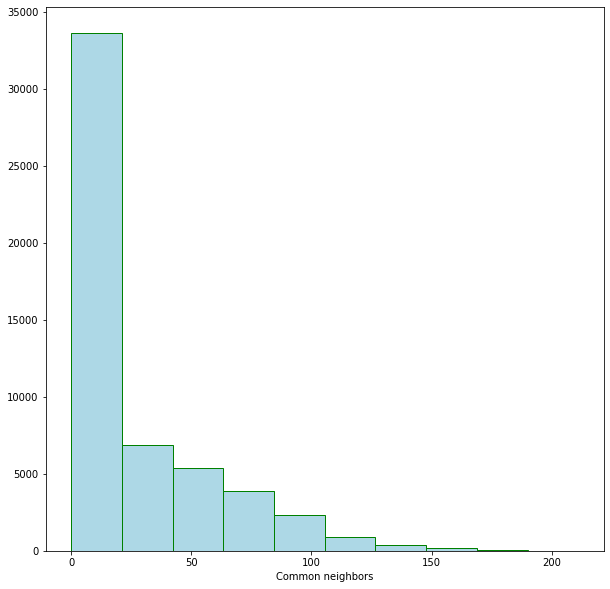

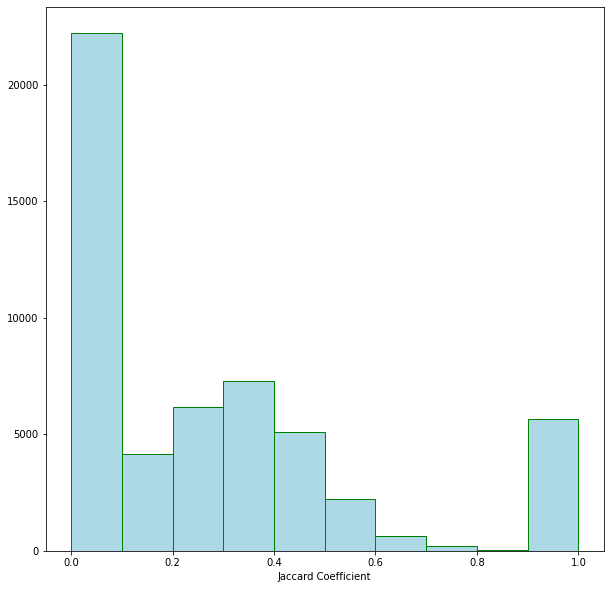

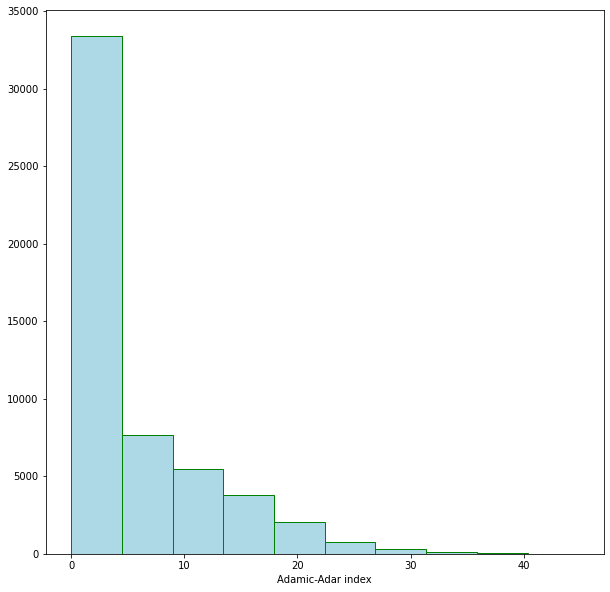

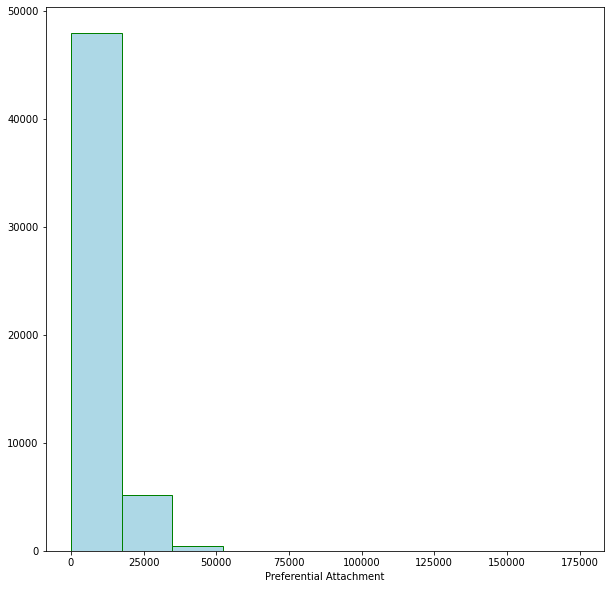

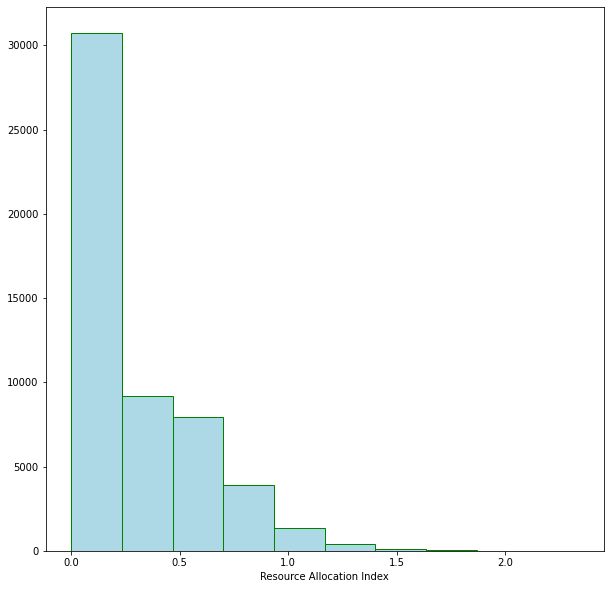

In [ ]:
from matplotlib.pyplot import hist

def draw_col(col, label):

  plt.figure(figsize=(10,10))
  plt.hist(xdf[col], color = "lightblue", ec="green")#, log=True)
  plt.xlabel(label)
  plt.show()

draw_col('CN', 'Common neighbors')
draw_col('JC', 'Jaccard Coefficient')
draw_col('AA', 'Adamic-Adar index')
draw_col('PA', 'Preferential Attachment')
draw_col('RA', 'Resource Allocation Index')


In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X = xdf.drop(columns=['Connection',  'PA']).values
y = xdf['Connection']


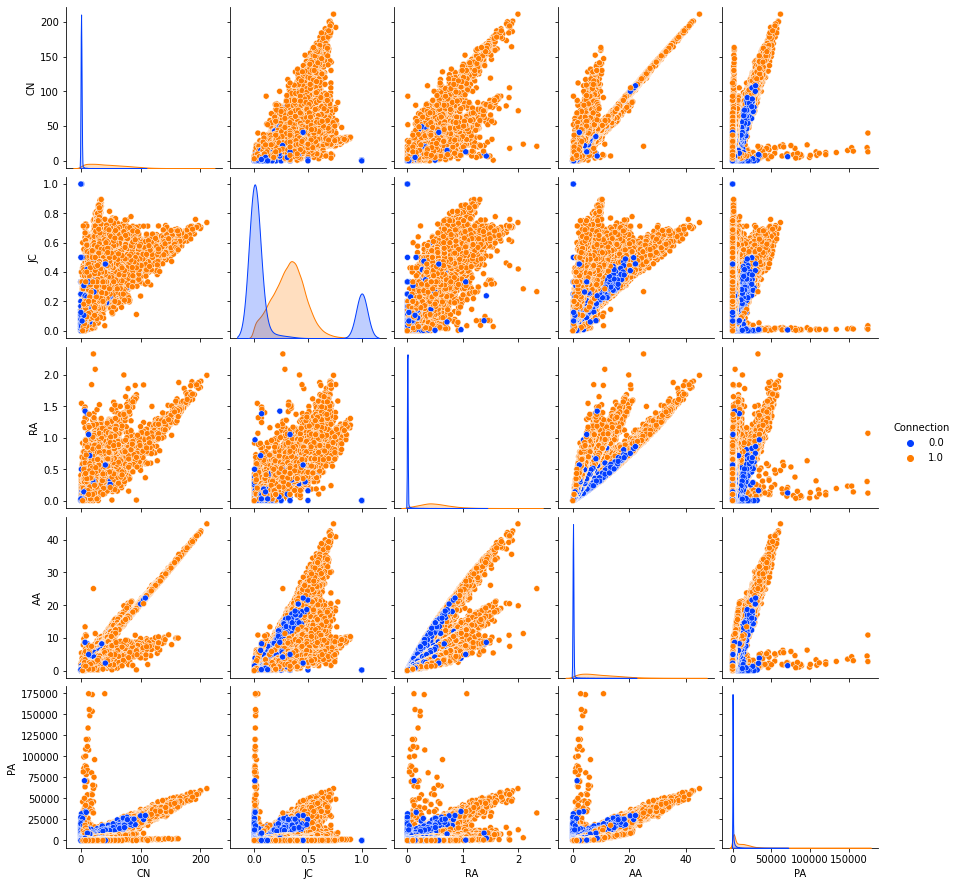

In [ ]:
import seaborn as sns
sns.pairplot(df, hue="Connection", palette='bright')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    random_state = 0,
    train_size=.80
    )

X_train.shape

(42936, 4)

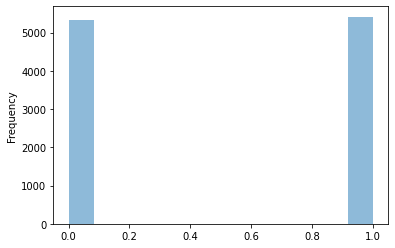

In [ ]:
y_test.plot.hist(bins=12, alpha=0.5)

In [ ]:
scaler = preprocessing.MinMaxScaler()
xFit = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train = X_train_scaled
X_test =  X_test_scaled

In [ ]:
!pip install sklearn_evaluation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Classifier 1: Random Forest Classifier

Grid best parameter (max. accuracy):  {'max_depth': 5, 'n_estimators': 100}
Grid best score (accuracy):  0.972610453220819
{'max_depth': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97      5319
         1.0       0.96      0.99      0.97      5415

    accuracy                           0.97     10734
   macro avg       0.97      0.97      0.97     10734
weighted avg       0.97      0.97      0.97     10734



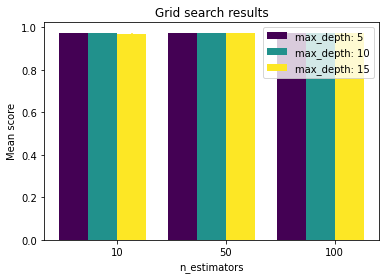

In [ ]:
# Classifier 1
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, auc, roc_curve, roc_auc_score,confusion_matrix
from sklearn_evaluation import plot
from sklearn.metrics import classification_report, confusion_matrix
clf1 = RandomForestClassifier()

# parameters
param = {'n_estimators' : [10,50,100], 'max_depth' : [5,10,15]}

# model
grid_clf_acc1 = GridSearchCV(clf1, param_grid = param)

# train the model
grid_clf_acc1.fit(X_train_scaled, y_train)

print('Grid best parameter (max. accuracy): ', grid_clf_acc1.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc1.best_score_)

plot.grid_search(grid_clf_acc1.cv_results_, change='n_estimators', kind='bar')

# print best parameter after tuning
print(grid_clf_acc1.best_params_)
grid1_predictions = grid_clf_acc1.predict(X_test)

# print classification report
print(classification_report(y_test, grid1_predictions))

# Classifier 2


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver lb

Grid best parameter (max. accuracy):  {'penalty': 'none'}
Grid best score (accuracy):  0.9636901954617872
{'penalty': 'none'}
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      5319
         1.0       0.98      0.95      0.96      5415

    accuracy                           0.96     10734
   macro avg       0.96      0.96      0.96     10734
weighted avg       0.96      0.96      0.96     10734



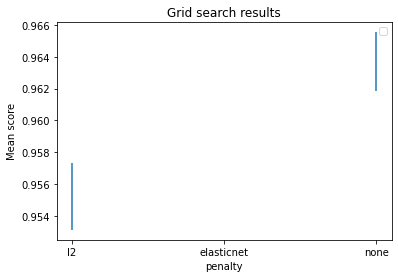

In [ ]:
# classifier
from sklearn.linear_model import LogisticRegression

clf3 = LogisticRegression(random_state=0)

param = {
  'penalty':['l1', 'l2', 'elasticnet', 'none']
}

# model
grid_clf_acc3 = GridSearchCV(clf3, param_grid = param)

# train the model
grid_clf_acc3.fit(X_train_scaled, y_train)

print('Grid best parameter (max. accuracy): ', grid_clf_acc3.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc3.best_score_)



plot.grid_search(grid_clf_acc3.cv_results_, change=('penalty'))
print(grid_clf_acc3.best_params_)
grid3_predictions = grid_clf_acc3.predict(X_test)

# print classification report
print(classification_report(y_test, grid3_predictions))

# SVM

{'C': 10, 'kernel': 'rbf'}
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      5319
         1.0       0.97      0.98      0.97      5415

    accuracy                           0.97     10734
   macro avg       0.97      0.97      0.97     10734
weighted avg       0.97      0.97      0.97     10734



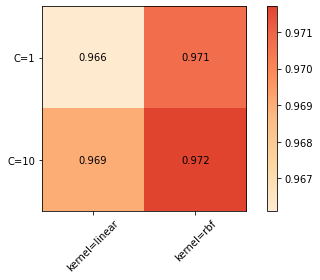

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn_evaluation import plot

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
grid_clf_svm = GridSearchCV(svc, parameters)

grid_clf_svm.fit(X_train_scaled, y_train)

plot.grid_search(grid_clf_svm.cv_results_, change=('kernel', 'C'))

print(grid_clf_svm.best_params_)
grid_svm_predictions = grid_clf_svm.predict(X_test)

# print classification report
print(classification_report(y_test, grid_svm_predictions))

# Decision Tree

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_message, FitFailed

{'criterion': 'entropy', 'splitter': 'best'}
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      5319
         1.0       0.96      0.96      0.96      5415

    accuracy                           0.96     10734
   macro avg       0.96      0.96      0.96     10734
weighted avg       0.96      0.96      0.96     10734



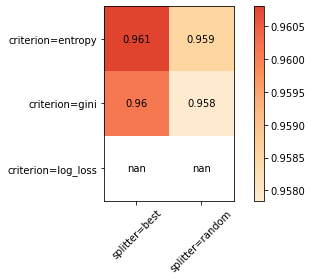

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

parameters = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
}
clfdt = DecisionTreeClassifier(random_state=0)
grid_clf_dt = GridSearchCV(clfdt, parameters)

grid_clf_dt.fit(X_train_scaled, y_train)

plot.grid_search(grid_clf_dt.cv_results_, change=('criterion', 'splitter'))

print(grid_clf_dt.best_params_)
grid_dt_predictions = grid_clf_dt.predict(X_test)

# print classification report
print(classification_report(y_test, grid_dt_predictions))

# Naive Bayes Classifier

/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warning

{'criterion': 'entropy', 'splitter': 'best'}
              precision    recall  f1-score   support

         0.0       0.99      0.61      0.76      5319
         1.0       0.72      0.99      0.84      5415

    accuracy                           0.80     10734
   macro avg       0.86      0.80      0.80     10734
weighted avg       0.85      0.80      0.80     10734



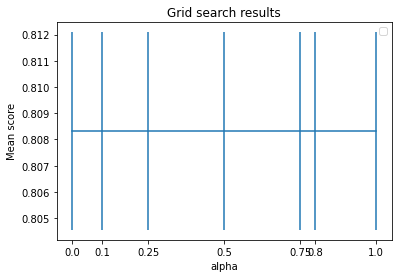

In [ ]:
from sklearn.naive_bayes import BernoulliNB

parameters = {
    'alpha': [0.0, 0.1, 0.25, 0.5, 0.75, 0.8, 1.0],
}
clfnb = BernoulliNB()
grid_clf_nb = GridSearchCV(clfnb, parameters)

grid_clf_nb.fit(X_train_scaled, y_train)

plot.grid_search(grid_clf_nb.cv_results_, change=('alpha'))

print(grid_clf_dt.best_params_)
grid_nb_predictions = grid_clf_nb.predict(X_test)

# print classification report
print(classification_report(y_test, grid_nb_predictions))